# Colorful-Image-Colorization

## Imports and constants

In [135]:
import numpy as np
import csv
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D, Conv2DTranspose
from tensorflow.keras import regularizers
from keras.models import Model
import os
import pandas as pd
from skimage import io, color
from skimage.transform import resize
import cv2
import sklearn.neighbors as nn
from matplotlib import pyplot as plt
import seaborn as sns
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

gpus = tf.config.list_physical_devices('GPU')
print(f'Detected gpus: {gpus}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


Detected gpus: []


In [4]:
BATCH_SIZE = 32 # Size of the batch
SIZE = 256
IMAGE_SIZE = (SIZE, SIZE) # Input image size
OUT_CLASSES = 313 # Number of bins
SIGMA = 5 # Sigma value for Gaussian smoothing
EPOCHS = 1000 # Number of epochs, early stopping implemented
PATIENCE = 5 # Training patience for early stopping

## Notes

### Preprocessing

- inspired by https://github.com/foamliu/Colorful-Image-Colorization
    - used AB space Quantization and interpolation technique

- ImageNet-Mini dataset (Only ~35k images in 1000 categories)
- CIE LAB Color space
- Lightness channel as input
- AB channels as ground truth
- Ground truth as one-hot-encoding

### Network architecture

- inspired by the original paper
- https://github.com/richzhang/colorization/blob/master/colorizers/eccv16.py
- switched from Adam to SGD
- LR auto decrease implemented (original paper decrements after 200k iterations)

### Paper summary

The authors chose to solve the problem using multinomial classification - as opposed to other approaches that use regression. Preprocessing starts by converting the RGB image into a LAB color spectrum. The lightness channel is used as input for training. The values in the AB channels are then encoded as follows:

All values in AB space are quantized into 313 bins of size 10x10. The AB values of each pixel from the input are then processed to find the 5 nearest-nearest bins for a given pixel using a 5-nearest-neighbor matcher. The distances to these bins are then further smoothed using Gaussian blurring and then stored as categories at the corresponding location in the 1D one-hot vector.

The network architecture is a simple sequential model consisting of convolution and batch normalization layers. In the original paper 'Adam' solver was used with decaying learning rate after 200k iterations.

### Gathered knowledge

- advanced techniques on preprocessing
- dataset search (ImageNet was too big, I had to search for a smaller one)
- Setting up a GPU computing libraries

#### Extract image paths into CSV folder

In [276]:
def create_csv(folder, out_name):
    with open(out_name, newline='', mode='w+') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['path'])
        for root, dirs, files in os.walk(os.path.join(os.getcwd(), "imagenet-mini", folder)):
            path = root.split(os.sep)
            for file in files:
                writer.writerow([os.path.join(root, file)])
    

create_csv('train', 'train.csv') 
create_csv('val', 'val.csv')

#### Load into Pandas dataframe

In [277]:
train = pd.read_csv('train.csv')
test = pd.read_csv('val.csv')

#### Quantizied ab color space with grid size 10

'Divide' AB color space into square bins of size 10x10. q_ab contains middle points of all bins to use in the interpolation. Interpolation is using 5-nearestneighbors algorithm.

In [278]:
q_ab = np.load("pts_in_hull.npy")
q_ab.shape[0]

313

#### Create generators

In [279]:
class Generator(tf.keras.utils.Sequence):
    
    def __init__(self, dataframe, dim=(256, 256, 1), batch_size=BATCH_SIZE):
        
        self.df = dataframe
        self.dim = dim
        self.batch_size = batch_size
        self.neighbors = nn.NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(q_ab)
        #self.on_epoch_end()
        
    def __getitem__(self, index):
        
        # take batch_size images from df
        current_rows = self.df[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_x = np.empty((self.batch_size, 256, 256, 1), dtype=np.float32) # batch_size x image
        batch_y = np.empty((self.batch_size, 64, 64, OUT_CLASSES), dtype=np.float32) # batch_size x out_size x one-hot-vector (313)
        
        # load images, resize, convert to lab, shift scale
        i = 0
        for index, row in current_rows.iterrows():
            bgr = cv2.imread(row.path)
            bgr = cv2.resize(bgr, IMAGE_SIZE, cv2.INTER_CUBIC)
            
            gray = cv2.imread(row.path, 0)
            gray = cv2.resize(gray, IMAGE_SIZE, cv2.INTER_CUBIC)
            
            lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
            lab = cv2.resize(lab, (64, 64), cv2.INTER_CUBIC)
            
            ab = lab[:, :, 1:].astype(np.int32) - 128
            
            x = gray / 255.0
            y = self.__encode_to_color_bins(ab)
            
            batch_x[i, :, :, 0] = x
            batch_y[i] = y
            i += 1

        return batch_x, batch_y
    
    def __encode_to_color_bins(self, ab_channels):
        a = np.ravel(ab_channels[:, :, 0]) # 1d a channel
        b = np.ravel(ab_channels[:, :, 1]) # 1d b channel
        ab = np.vstack((a, b)).T # ab values as points
        
        # distance and indices of nearest neighbors for each pixel shape (64 * 64, 5)
        dist, idx = self.neighbors.kneighbors(ab) 
        
        # apply gaussian smoothing, returns shape (4096, 5) -> needs to  be changed into (64, 64, 313)
        smoothed = self.__smooth_gaus(dist, SIGMA)
        
        # format into desired output shape (64, 64, 313)
        y = np.zeros((4096, 313))
        idx_pts = np.arange(ab.shape[0])[:, np.newaxis]
        y[idx_pts, idx] = smoothed
        y = y.reshape(64, 64, 313)  
        
        return y
    
    def __smooth_gaus(self, values, sigma):
        # Gaussian smoothing  
        smoothed = np.exp(-values ** 2 / (2 * sigma ** 2))      
        smoothed = smoothed / np.sum(smoothed, axis=1)[:, np.newaxis]
        return smoothed
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    
train_gen = Generator(train, batch_size = BATCH_SIZE)
test_gen = Generator(test, batch_size = BATCH_SIZE)

## Model

In [7]:
def get_model(input_shape, out_classes):
    
    reg = regularizers.l2(1e-3)
    
    input = Input(shape=input_shape)
    
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_1', kernel_regularizer=reg)(input)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_2', kernel_regularizer=reg, strides=(2, 2))(conv1_1)
    norm1 = BatchNormalization(name='norm1')(conv1_2)

    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_1', kernel_regularizer=reg)(norm1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_2', kernel_regularizer=reg, strides=(2, 2))(conv2_1)
    norm2 = BatchNormalization(name='norm2')(conv2_2)

    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_1', kernel_regularizer=reg)(norm2)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_2', kernel_regularizer=reg)(conv3_1)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_3', strides=(2, 2))(conv3_2)
    norm3 = BatchNormalization(name='norm3')(conv3_3)

    conv4_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv4_1', kernel_regularizer=reg)(norm3)
    conv4_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv4_2', kernel_regularizer=reg)(conv4_1)
    conv4_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv4_3', kernel_regularizer=reg)(conv4_2)
    norm4 = BatchNormalization(name='norm4')(conv4_3)

    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', dilation_rate=2, name='conv5_1', kernel_regularizer=reg)(norm4)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', dilation_rate=2, name='conv5_2', kernel_regularizer=reg)(conv5_1)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', dilation_rate=2, name='conv5_3', kernel_regularizer=reg)(conv5_2)
    norm5 = BatchNormalization(name='norm5')(conv5_3)

    conv6_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', dilation_rate=2, name='conv6_1', kernel_regularizer=reg)(norm5)
    conv6_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', dilation_rate=2, name='conv6_2', kernel_regularizer=reg)(conv6_1)
    conv6_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', dilation_rate=2, name='conv6_3', kernel_regularizer=reg)(conv6_2)
    norm6 = BatchNormalization(name='norm6')(conv6_3)

    conv7_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv7_1', kernel_regularizer=reg)(norm6)
    conv7_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv7_2', kernel_regularizer=reg)(conv7_1)
    conv7_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv7_3', kernel_regularizer=reg)(conv7_2)
    norm7 = BatchNormalization(name='norm7')(conv7_3)

    convTranspose = Conv2DTranspose(256, kernel_size=4, strides=(2, 2), padding='same', name='covnTranspose', kernel_regularizer=reg)(norm7)
    conv8_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv8_1', kernel_regularizer=reg)(convTranspose)
    conv8_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv8_2', kernel_regularizer=reg)(conv8_1)
    conv8_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv8_3', kernel_regularizer=reg)(conv8_2)
    norm8 = BatchNormalization(name='norm8')(conv8_3)

    outputs = Conv2D(out_classes, (1, 1), activation='softmax', padding='same', name='prediction')(norm8)

    model = Model(inputs=input, outputs=outputs, name="Colorizer")
    return model

## Training

In [8]:
input_shape = (256, 256, 1)

#model = get_model(input_shape, OUT_CLASSES)
model = tf.keras.models.load_model("model.h5")
sgd = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
model_checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

callbacks = [tensor_board, model_checkpoint, early_stop, reduce_lr]

model.summary()
model.fit(train_gen, 
          validation_data=test_gen, 
          epochs=EPOCHS,
          callbacks=callbacks,
          batch_size=BATCH_SIZE,
          verbose=1, steps_per_epoch=34745//BATCH_SIZE, validation_steps=3923//BATCH_SIZE)

Model: "Colorizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 256, 256, 64)      640       
                                                                 
 conv1_2 (Conv2D)            (None, 128, 128, 64)      36928     
                                                                 
 norm1 (BatchNormalization)  (None, 128, 128, 64)      256       
                                                                 
 conv2_1 (Conv2D)            (None, 128, 128, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 64, 64, 128)       147584    
                                                                 
 norm2 (BatchNormalization)  (None, 64, 64, 128)       51

In [35]:
%load_ext tensorboard
%tensorboard --logdir logs

## Evaluation

In [281]:
model = tf.keras.models.load_model("model.h5")

In [18]:
def colorize_image(gray):
    x_test = np.empty((1, 256, 256, 1), dtype=np.float32)
    x_test[0, :, :, 0] = gray / 255.
    
    predict = model.predict(x_test) # predict
    
    # reshape and reweight predicted AB channels
    predict_reshaped = predict.reshape((64 * 64, 313)) # reshape
    predict_reshaped = np.exp(np.log(predict_reshaped + 1e-8) / 0.38) #
    predict_reweighted = predict_reshaped / np.sum(predict_reshaped, 1)[:, np.newaxis]
    
    # load points of the quantizied AB space
    ab_points = np.load("pts_in_hull.npy")
    a_points = ab_points[:, 0].reshape((1, 313))
    b_points = ab_points[:, 1].reshape((1, 313))
    a_X = np.sum(predict_reweighted * a_points, 1).reshape((64, 64))
    b_X = np.sum(predict_reweighted * b_points, 1).reshape((64, 64))
    
    # Resize to output size and shift AB to the middle
    a_X = cv2.resize(a_X, IMAGE_SIZE, cv2.INTER_CUBIC) + 128
    b_X = cv2.resize(b_X, IMAGE_SIZE, cv2.INTER_CUBIC) + 128

    # prepare result
    out = np.zeros((SIZE, SIZE, 3), dtype=np.int32)
    
    # set original gray image as output L channel
    out[:, :, 0] = gray
    
    # predicted, reweighted, resized and rescaled A and B channels
    out[:, :, 1] = a_X
    out[:, :, 2] = b_X

    out = out.astype(np.uint8)
    out_bgr = cv2.cvtColor(out, cv2.COLOR_LAB2BGR)
    out_bgr = out_bgr.astype(np.uint8)
    rgb = cv2.cvtColor(out_bgr, cv2.COLOR_BGR2RGB)
    
    return rgb
    

### Metric evaluation


#### Color distribution MSE

Compute mean squared error difference between color distributions for each channel.

In [314]:
def distribution_mse(predicted, gt):
    mse_r = np.mean((np.histogram(predicted[:, :, 0], bins=256)[0] - np.histogram(gt[:, :, 0], bins=256)[0]) ** 2)
    mse_g = np.mean((np.histogram(predicted[:, :, 1], bins=256)[0] - np.histogram(gt[:, :, 1], bins=256)[0]) ** 2)
    mse_b = np.mean((np.histogram(predicted[:, :, 2], bins=256)[0] - np.histogram(gt[:, :, 2], bins=256)[0]) ** 2)
    
    a = np.histogram(predicted_rgb[:, :, 0], bins=256)
    return mse_r + mse_g + mse_b


def predict_and_distribution_mse(image):
    gray = cv2.imread(image, 0)
    gray = cv2.resize(gray, (256, 256), cv2.INTER_CUBIC)
    predicted_rgb = colorize_image(gray)

    gt = cv2.imread(image)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    gt = cv2.resize(gt, (256, 256), cv2.INTER_CUBIC)
    return distribution_mse(predicted_rgb, gt)
    

#### Peek Signal to Noice Ratio (PSNR)

PSNR shows a ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation.

In [362]:
def psnr_channel(img1, img2, max_value=255):
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

def psnr_rgb(img1, img2):
    r = psnr_channel(img1[:, :, 0], img2[:, :, 0])
    g = psnr_channel(img1[:, :, 1], img2[:, :, 1])
    b = psnr_channel(img1[:, :, 2], img2[:, :, 2])
    return r + g + b

def predict_and_psnr(image):
    gray = cv2.imread(image, 0)
    gray = cv2.resize(gray, (256, 256), cv2.INTER_CUBIC)
    predicted_rgb = colorize_image(gray)

    gt = cv2.imread(image)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    gt = cv2.resize(gt, (256, 256), cv2.INTER_CUBIC)
    return psnr_rgb(predicted_rgb, gt)

#### Average metric in evaluation dataset

- Load a detaset the model never seen and compute distribution MSE and PSNR and average it

In [363]:
for root, dirs, f in os.walk(os.path.join(os.getcwd(), "tiny_imagenet")):
        files = f
mse = 0
psnr = 0
for file in files:
    image_path = os.path.join("tiny_imagenet", file)
    mse += predict_and_distribution_mse(image_path)
    psnr += predict_and_psnr(image_path)
    
    
print("AVERAGE MSE: " + str(mse / len(files)))
print("AVERAGE PSNR: " + str(psnr / len(files)))

AVERAGE MSE: 345506.1010572139
AVERAGE PSNR: 72.46179198134753


### Color distribution

- Visually compare distribution of the pixel values
- For better visual effect, the line is continuous and has been smoothed

In [337]:
def color_distribution(image):
    
    gray = cv2.imread(image, 0)
    gray = cv2.resize(gray, (256, 256), cv2.INTER_CUBIC)
    predicted_rgb = colorize_image(gray)
    
    gt = cv2.imread(image)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    gt = cv2.resize(gt, (256, 256), cv2.INTER_CUBIC)
    
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(25, 8))
    fig.suptitle("Smoothed density distribution in color channels, PSNR: " + str(psnr(predicted_rgb, gt)) + ", MSE: " + str(distribution_mse(predicted_rgb, gt)), fontsize=20)
    adjust = 0.15
    
    sns.kdeplot(ax=axes[0], data=gt[:,:,0].ravel(), color='orange', bw_adjust=adjust)
    sns.kdeplot(ax=axes[0], data=predicted_rgb[:,:,0].ravel(), color='red', bw_adjust=adjust)
    axes[0].set_title("Red")
    axes[0].set_xlabel("Intensity value")
    axes[0].legend(['Ground truth', 'Predicted'])
    
    sns.kdeplot(ax=axes[1], data=gt[:,:,1].ravel(), color='lime', bw_adjust=adjust)
    sns.kdeplot(ax=axes[1], data=predicted_rgb[:,:,1].ravel(), color='green', bw_adjust=adjust)
    axes[1].set_title("Green")
    axes[1].set_xlabel("Intensity value")
    axes[1].legend(['Ground truth', 'Predicted'])
        
    sns.kdeplot(ax=axes[2], data=gt[:,:,2].ravel(), color='dodgerblue', bw_adjust=adjust)
    sns.kdeplot(ax=axes[2], data=predicted_rgb[:,:,2].ravel(), color='blue', bw_adjust=adjust)
    axes[2].set_title("Blue")
    axes[2].set_xlabel("Intensity value")
    axes[2].legend(['Ground truth', 'Predicted'])
    
    plt.plot()

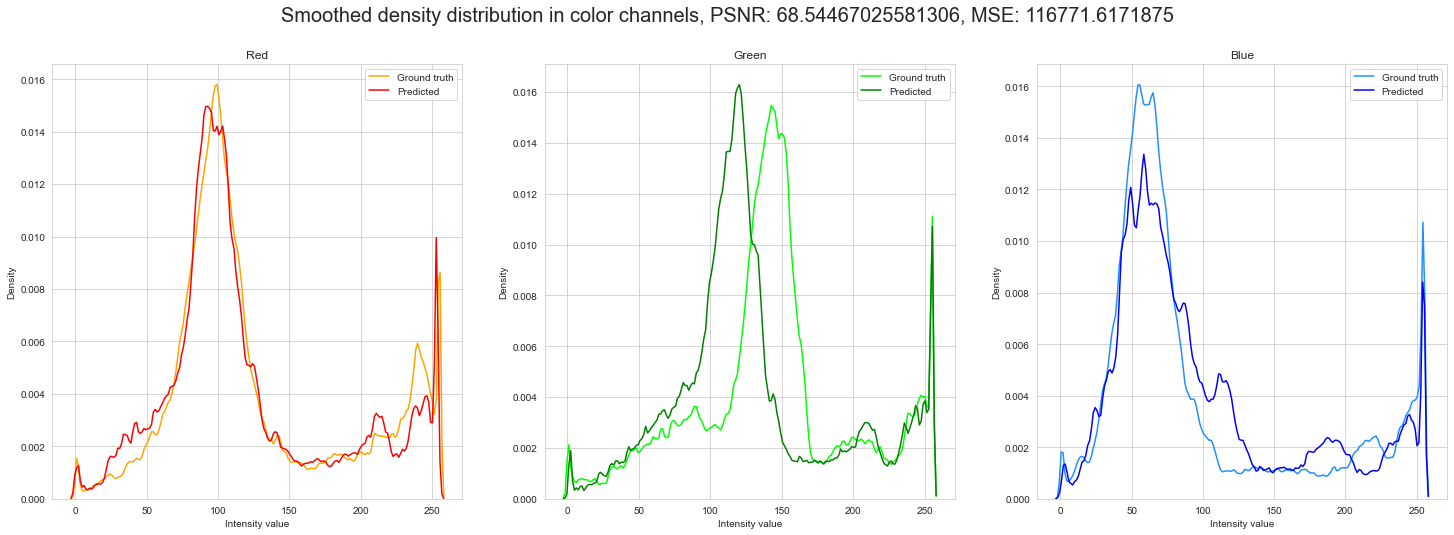

In [338]:
color_distribution("demo_images/dog.jpg")

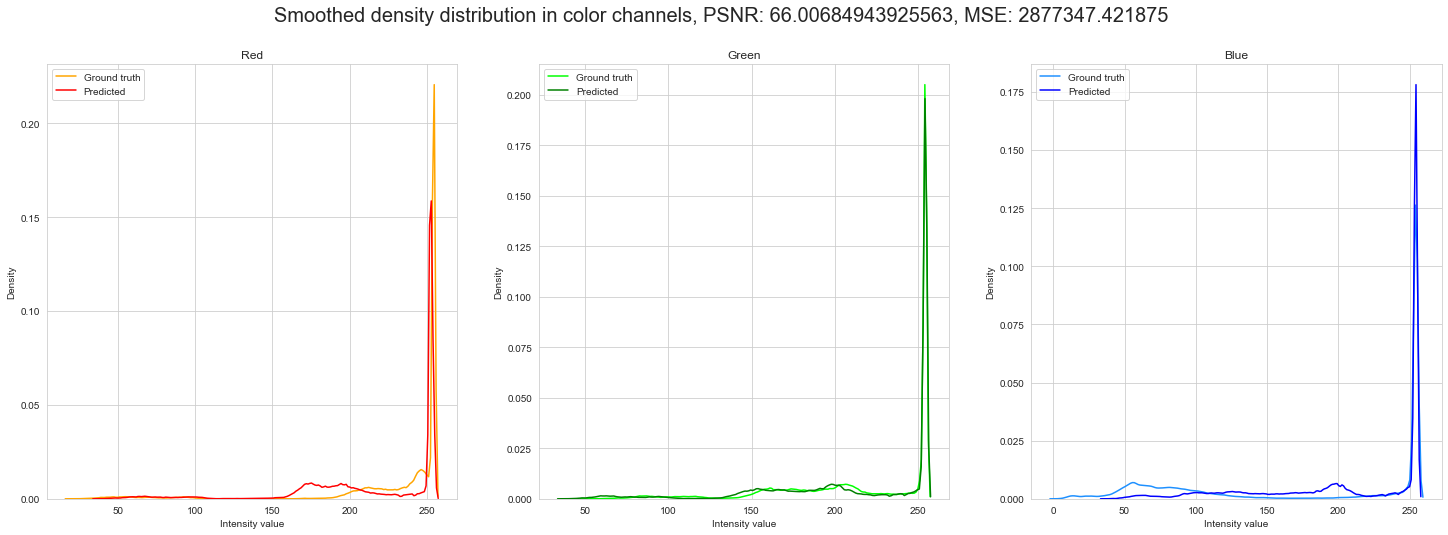

In [339]:
color_distribution("demo_images/lemon.png")

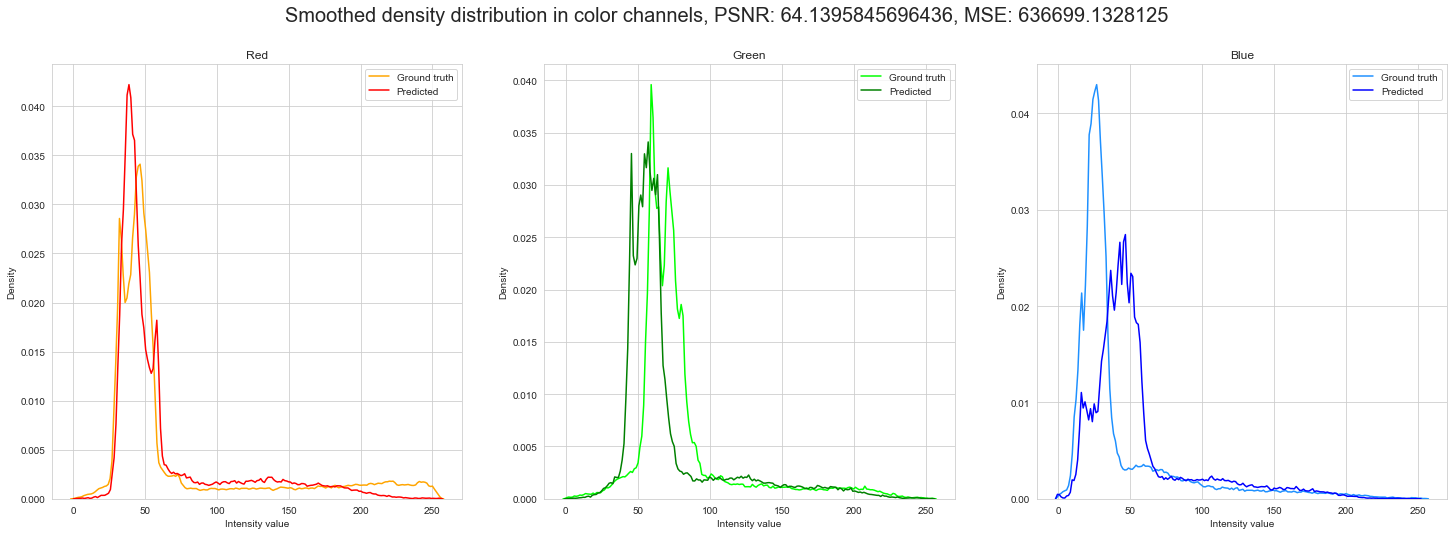

In [340]:
color_distribution("demo_images/bird.jpg")

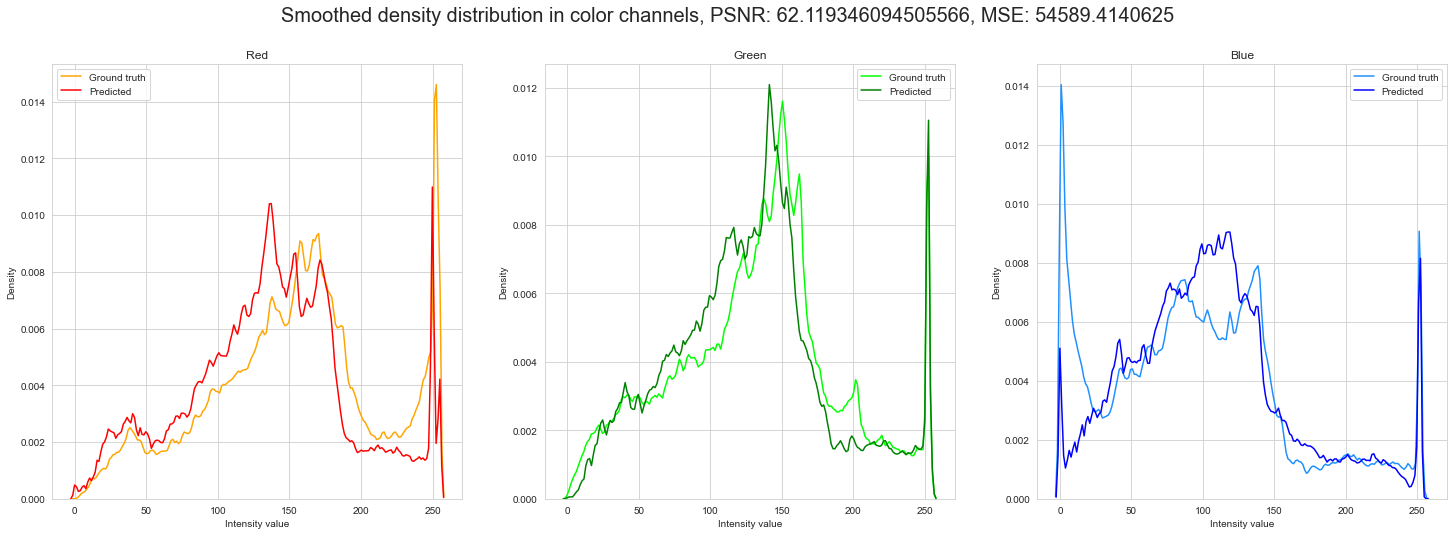

In [341]:
color_distribution("demo_images/snake.jpg")

### Visual comparison

Random images from the internet were chosen as evaluation inputs.

In [19]:
def compare_results(image):
    gray = cv2.imread(image, 0) # read in grayscale
    gray = cv2.resize(gray, (256, 256), cv2.INTER_CUBIC)
    rgb = colorize_image(gray)
    
    # load GT image for comparison
    gt = cv2.imread(image)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    gt = cv2.resize(gt, (256, 256), cv2.INTER_CUBIC)
    
    # display all three images next to each other
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(100,100))
    ax1.imshow(gray, cmap='gray')
    ax2.imshow(rgb)
    ax3.imshow(gt)

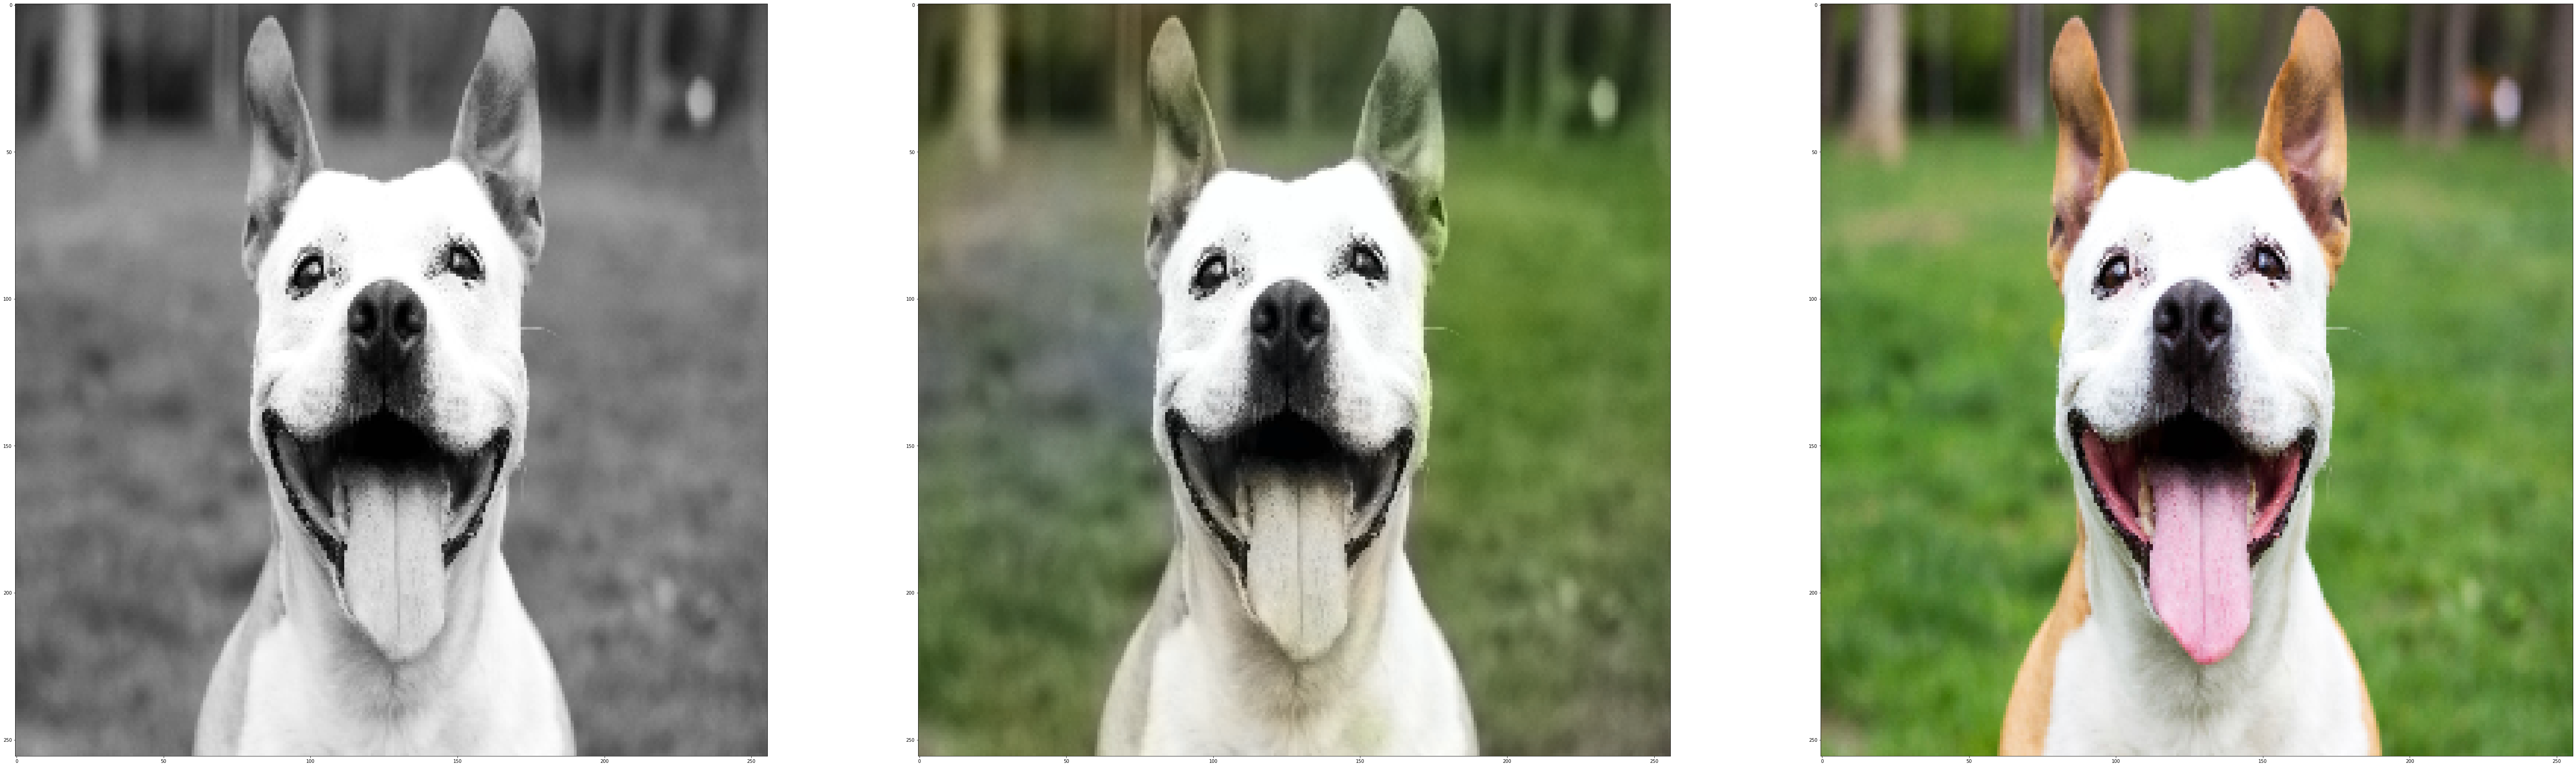

In [20]:
compare_results("demo_images/dog.jpg")

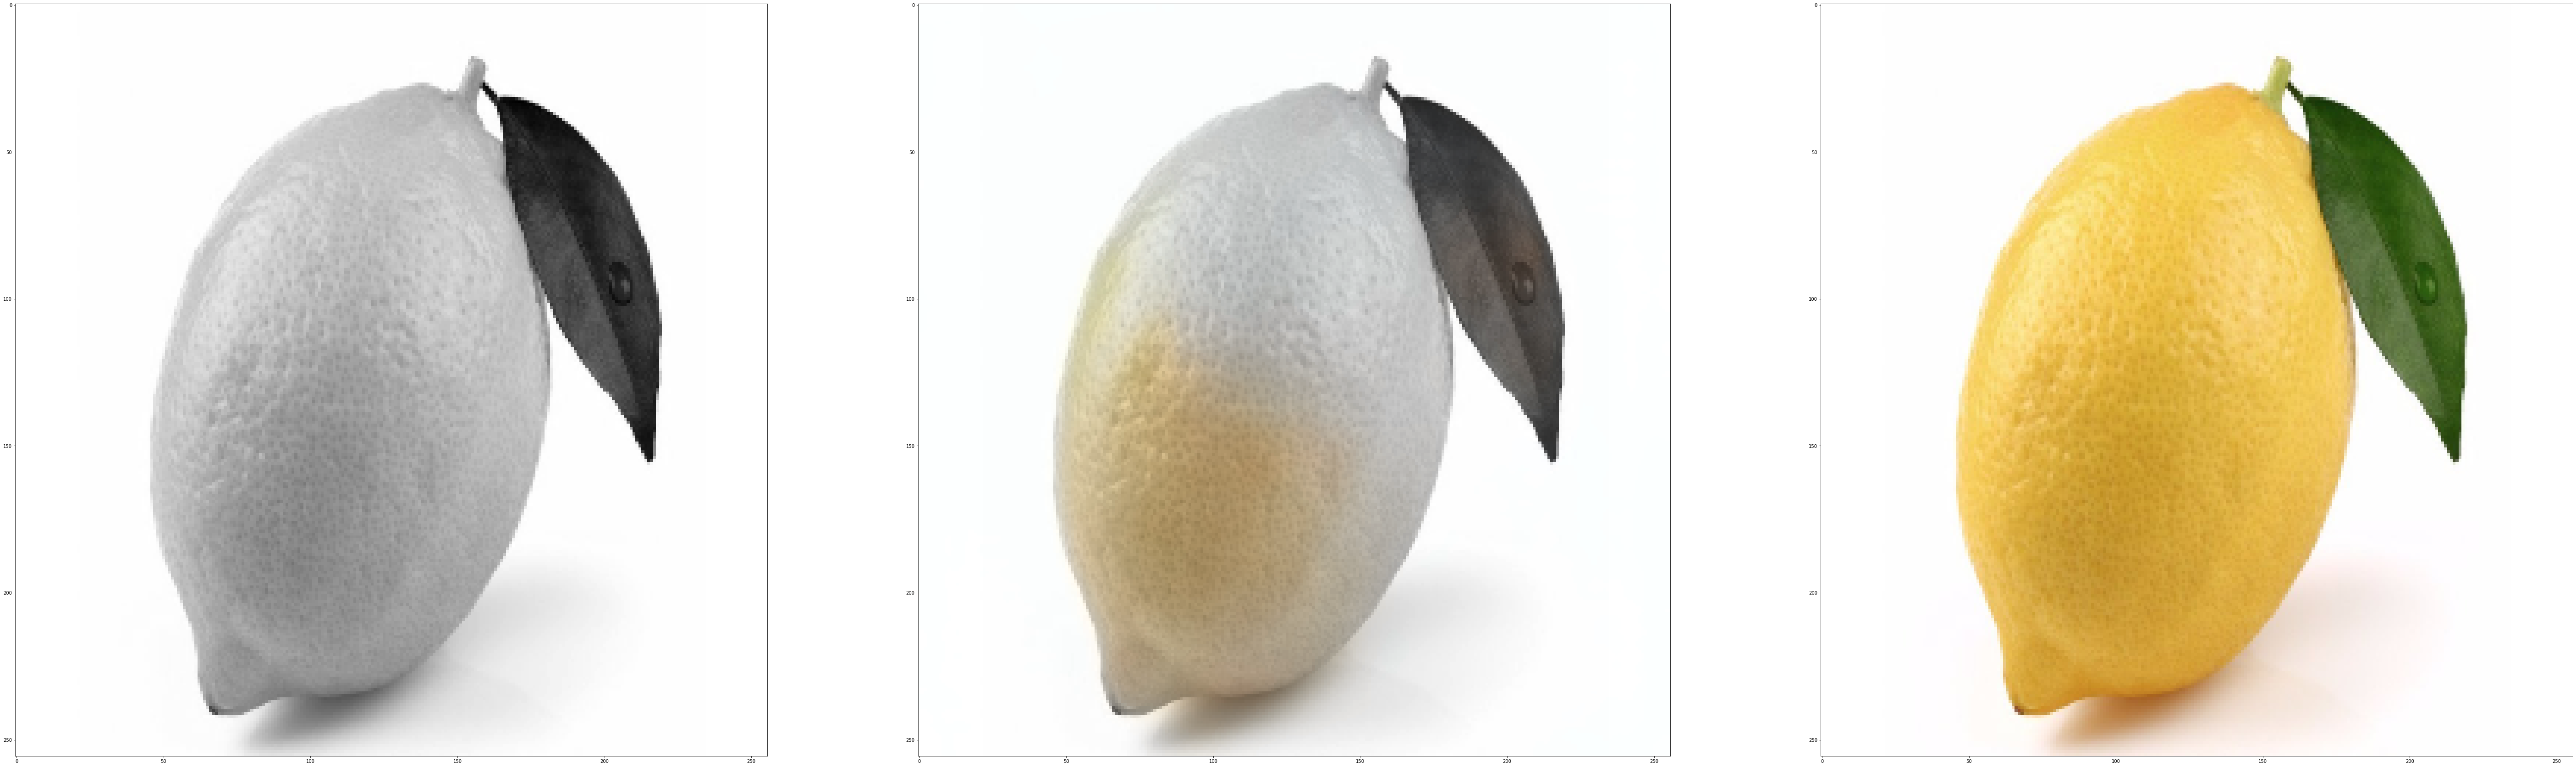

In [21]:
compare_results("demo_images/lemon.png")

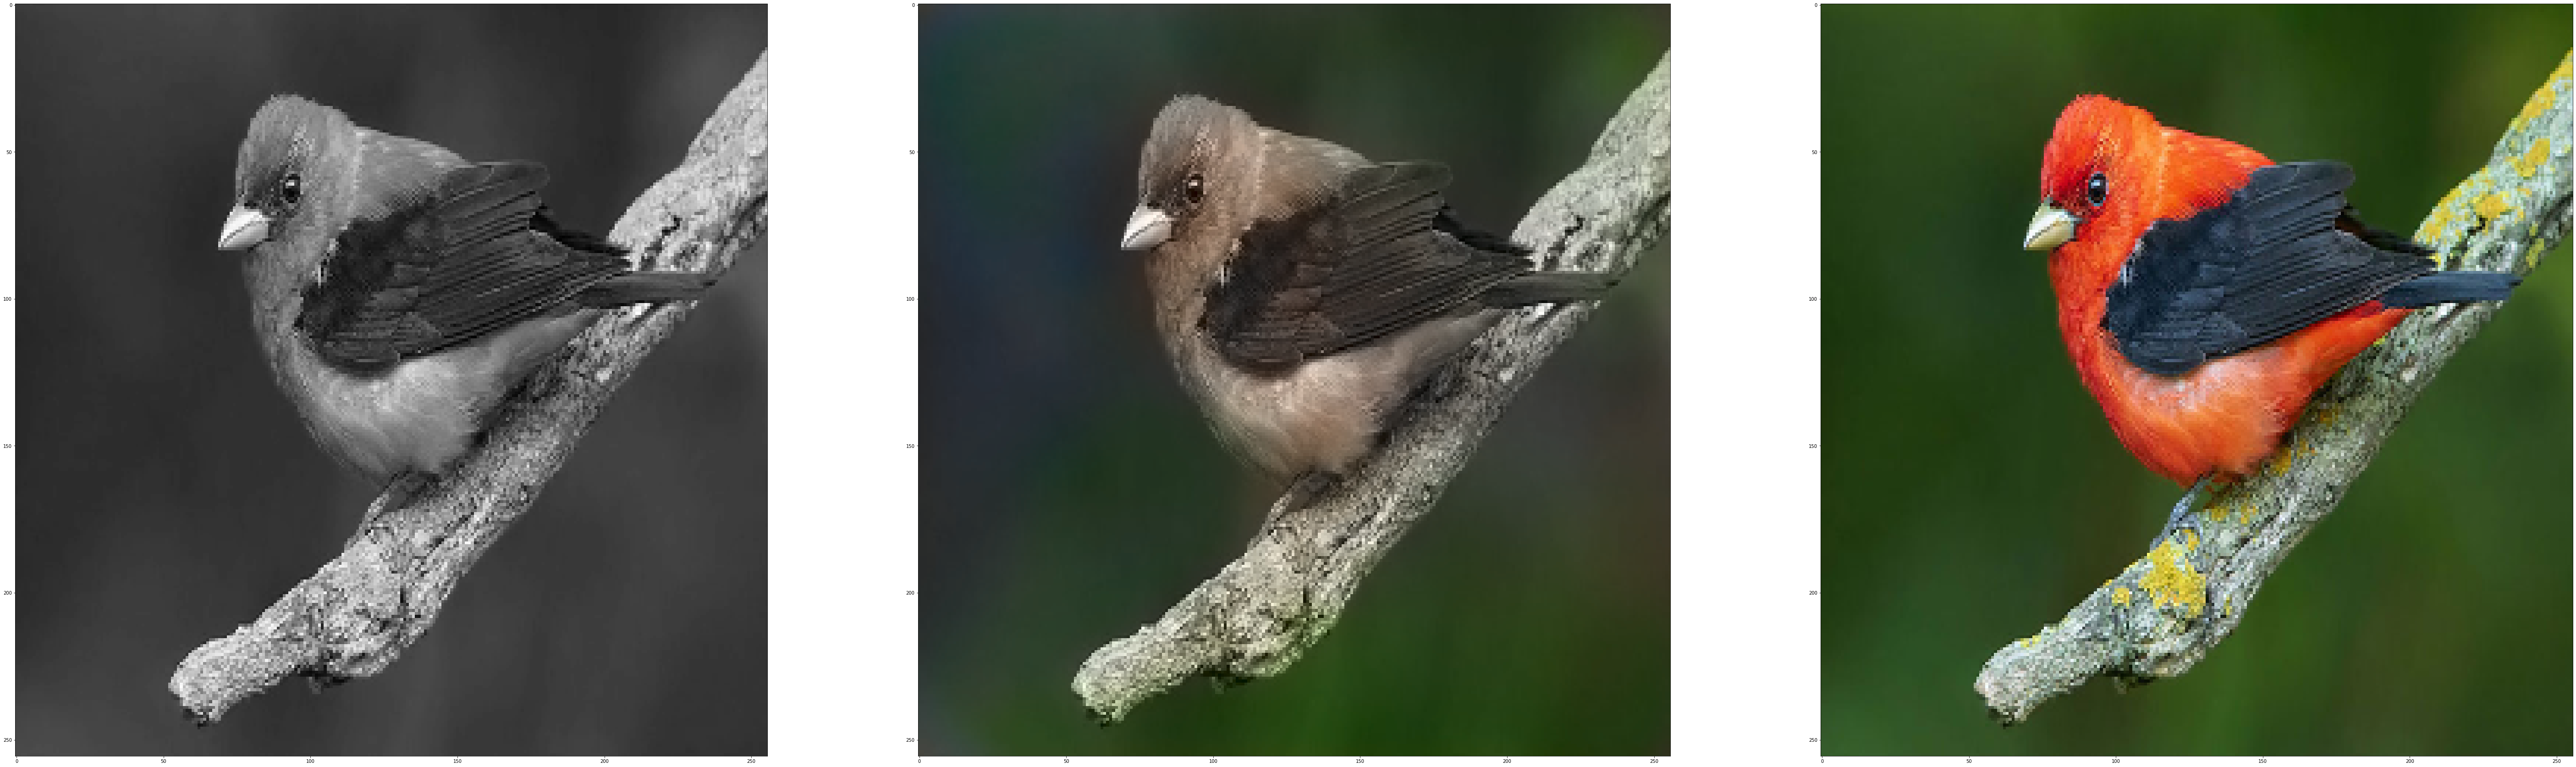

In [22]:
compare_results("demo_images/bird.jpg")

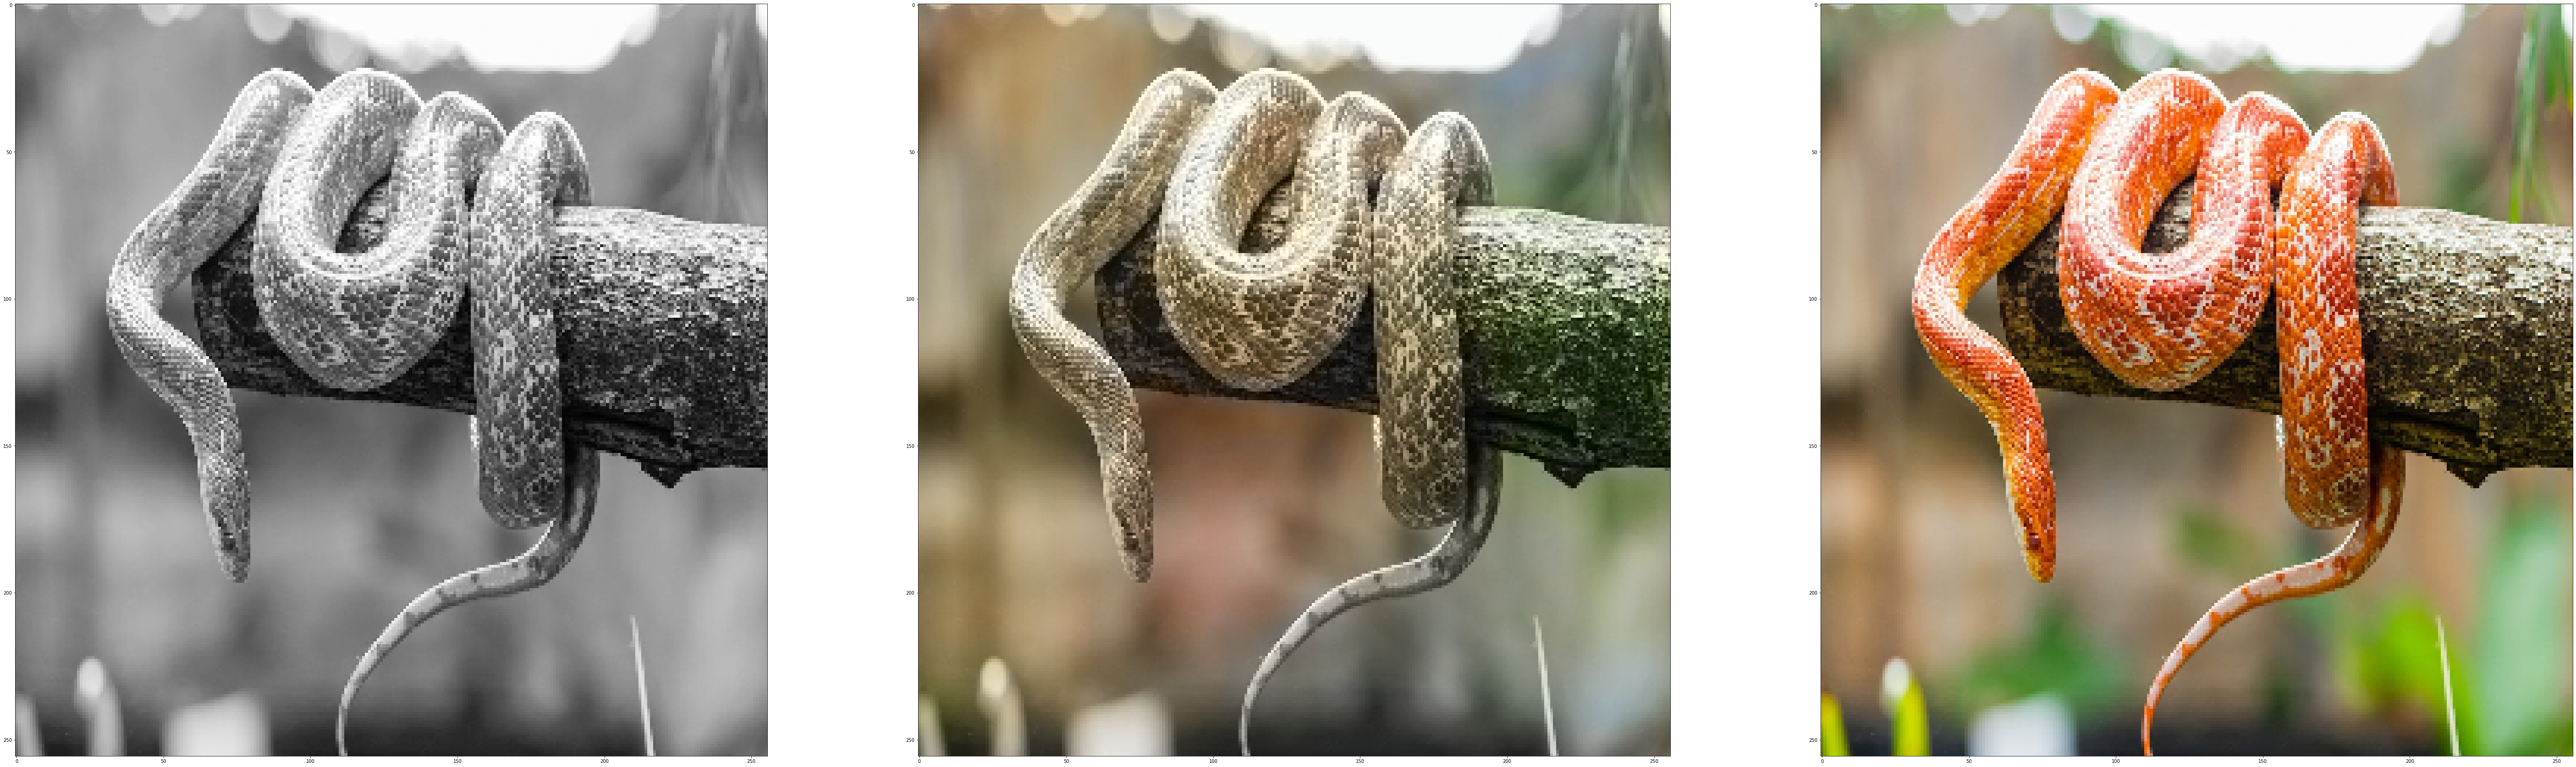

In [23]:
compare_results("demo_images/snake.jpg")

## Conclusion

The evaluation shows that the model has learned to reliably detect the background. This is certainly also due to the fact that the background generally occupies more space than the object itself. However, it can be seen that the model can detect some colors of the object in the image. Better results would certainly be obtained using a different dataset, e.g. the whole ImageNet, where more inputs are available for each class. Currently there are about 10-20 inputs available for each class.